# 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
torch.cuda.is_available()
import torchvision.datasets as datasets
from torch.nn import functional as F

# 2. Load MNIST Dataset

In [2]:
train_dataset= datasets.MNIST(root='/home/khaled/DSworkArea', train=True, transform=transforms.ToTensor(), download=True,)
test_dataset= datasets.MNIST(root='/home/khaled/DSworkArea', train=False, transform=transforms.ToTensor())

In [3]:
# print dataset info
print(train_dataset)
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/khaled/DSworkArea
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: /home/khaled/DSworkArea
    Split: Test
    StandardTransform
Transform: ToTensor()


In [4]:
# images size
print (train_dataset.data.size())
print("-----------------------")
print(test_dataset.data.size())

torch.Size([60000, 28, 28])
-----------------------
torch.Size([10000, 28, 28])


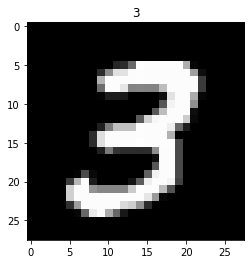

In [5]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset.data[7], cmap='gray')
plt.title('%i' % train_dataset.targets[7])
plt.show()

In [6]:
# split data to batches each batch contain 100 images
batch_size=100
train_load=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size)
test_load=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size)

In [7]:
# iteration on loader
dataiter=iter(train_load)
images,labels=dataiter.next()
print(images.shape)
print("-------------------")
print(labels.shape)

torch.Size([100, 1, 28, 28])
-------------------
torch.Size([100])


In [8]:
print("Number of images in training set: {}".format(len(train_dataset)))
print("Number of images in test set: {}".format(len(test_dataset)))
print("Number of batches in the train loader: {}".format(len(train_load)))
print("Number of batches in the test loader: {}".format(len(test_load)))

Number of images in training set: 60000
Number of images in test set: 10000
Number of batches in the train loader: 600
Number of batches in the test loader: 100


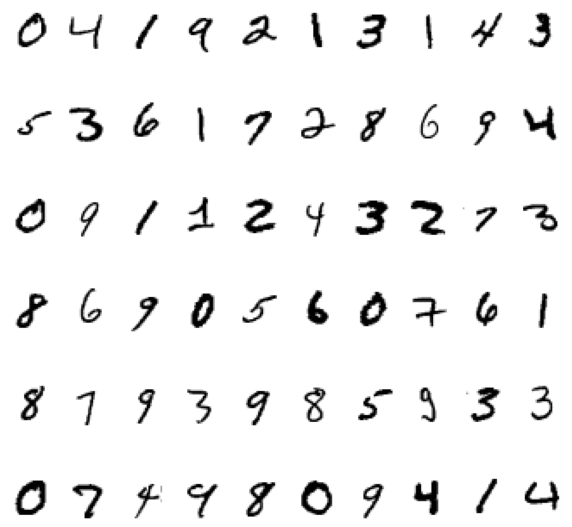

In [9]:
figure = plt.figure(figsize=(10,10))
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# 3. Build Model

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn1=nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.batchnorm1=nn.BatchNorm2d(8)
        self.relu=nn.ReLU()
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        self.cnn2=nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.batchnorm2=nn.BatchNorm2d(32)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 =nn.Linear(in_features=1568, out_features=600)
        self.fc2 =nn.Linear(in_features=600, out_features=10)
    def forward(self,x):
        out=self.cnn1(x)
        out=self.batchnorm1(out)
        out=self.relu(out)
        out=self.maxpool1(out)
        out=self.cnn2(out)
        out=self.batchnorm2(out)
        out=self.relu(out)
        out=self.maxpool2(out)
        out=out.view(-1,1568)
        out=self.fc1(out)
        out=self.relu(out)
        out=self.fc2(out)
        return out

In [11]:
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 20
model=CNN().to(device)
loss_function= nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(), lr=0.01)

# 4. Train your Model

In [16]:
def train_CNN(model, criterion,optimizer, dataLoader,devic):
    losses = []
    acc = []
    model.train()
    running_loss = 0.0
    running_corrects = 0.0
    for data in dataLoader:
        images,labels=data
        images=images.to(devic)
        labels=labels.to(devic)
        outputs=model(images)
        loss=criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _,preds=torch.max(outputs,1)
        running_loss +=loss.item()*images.size(0)
        running_corrects +=torch.sum(preds==labels.data)
    epoch_loss=running_loss/len(dataLoader)
    epoch_acc= running_corrects/len(dataLoader)
    return epoch_acc,epoch_loss

In [17]:
def vaildate_cnn(model, criterion, dataLoader, devic):
    losses = []
    acc = []
    model.eval()
    correct = 0.0
    running_loss = 0.0
    running_corrects = 0.0
    for data in dataLoader:
        images, labels = data
        images = images.to(devic)
        labels = labels.to(devic)
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs,1)
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(dataLoader)
    epoch_acc = running_corrects / len(dataLoader)
    return epoch_acc, epoch_loss

In [18]:
epochess = []
train_losses = []
test_losses = []
acc_training = []
acc_testing = []
for epoch in range (epochs):
    train_acc, train_epoch_loss = train_CNN(model,loss_function,optimizer,train_load,device)
    print('epoch',epoch,'---training accuarcy',train_acc,'--training loss',train_epoch_loss)
    train_losses.append(train_epoch_loss)
    acc_training.append(train_acc)

    test_acc, test_epoch_loss = vaildate_cnn(model,loss_function,test_load,device)
    print('epoch',epoch,'--testing accuarcy',test_acc,'---testing loss',test_epoch_loss)
    test_losses.append(test_epoch_loss)
    acc_testing.append(test_acc)

    epochess.append(epoch)

epoch 0 ---training accuarcy tensor(99.0433, device='cuda:0') --training loss 3.393076805068025
epoch 0 --testing accuarcy tensor(98.7700, device='cuda:0') ---testing loss 3.9289097460568883
epoch 1 ---training accuarcy tensor(99.1233, device='cuda:0') --training loss 3.194908398281162
epoch 1 --testing accuarcy tensor(98.8100, device='cuda:0') ---testing loss 3.8264308357902337
epoch 2 ---training accuarcy tensor(99.1833, device='cuda:0') --training loss 3.012590194159808
epoch 2 --testing accuarcy tensor(98.8000, device='cuda:0') ---testing loss 3.7319294710468967
epoch 3 ---training accuarcy tensor(99.2317, device='cuda:0') --training loss 2.8460478960187174
epoch 3 --testing accuarcy tensor(98.8300, device='cuda:0') ---testing loss 3.646201338735409
epoch 4 ---training accuarcy tensor(99.2783, device='cuda:0') --training loss 2.6937439976027235
epoch 4 --testing accuarcy tensor(98.8400, device='cuda:0') ---testing loss 3.5840308873157483
epoch 5 ---training accuarcy tensor(99.3350,

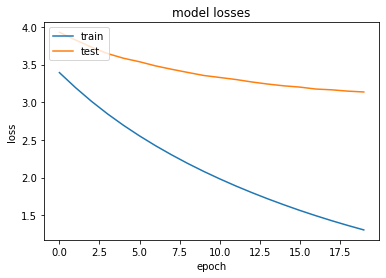

In [27]:
plt.plot(epochess,train_losses,test_losses)
plt.title('model losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()